In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
data_raw = pd.read_csv('pitches.csv')
# Print out size, shape, and column names
print("size: " + str(data_raw.size))
print("shape: " + str(data_raw.shape))
print("columns: " + str(data_raw.columns))

size: 114686160
shape: (2867154, 40)
columns: Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')


In [3]:
df = data_raw
# dropping useless columns and rows with null values
df = df.drop(["nasty", "zone", "type_confidence", "pitch_type", "ab_id", "event_num"], axis = 1)
df = df.dropna()
# drop balls, bunts, pitchouts
df = df[df.code.isin(['S', 'C', 'F', 'T', 'W', 'X', 'D', 'E'])]
print(df.shape)

(1803450, 34)


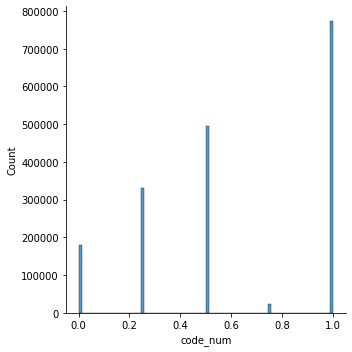

In [4]:
# convert pitch outcomes to numbers so they can be plotted
# higher number = better outcome
outcomes = {'S': 1, 'C': 1, 'W': 1, 'T': 0.75, 'F': 0.5
, 'X': 0.25, 'D': 0, 'E': 0 }
df['code_num'] = df['code'].map(outcomes)
df = df.drop(['code'], axis = 1)
sns.displot(df.code_num)

In [5]:
df = df.drop(["y0", "type", "b_score", "outs", "pitch_num", "b_count", "s_count", "on_1b", "on_2b", "on_3b"], axis = 1)

In [25]:
print(df.shape)
df.columns

(1803450, 24)


Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 'pfx_z',
       'code_num'],
      dtype='object')

In [6]:
import sklearn.model_selection as tts
features_train, features_test, labels_train, labels_test = tts.train_test_split(df.transpose()[:23].transpose(), df.code_num, test_size = 0.3, random_state = 69)

In [7]:
print(features_train.shape)
print(features_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(1262415, 23)
(541035, 23)
(1262415,)
(541035,)


In [8]:
# IMPORTANT: DO NOT TOUCH VAL UNTIL VALIDATION PHASE!!
features_test, features_val, labels_test, labels_val = tts.train_test_split(features_test, labels_test, test_size = 0.3, random_state = 420)

In [44]:
df.code_num.shape

(1803450,)

In [ ]:
from sklearn.neural_network import MLPRegressor
fear = MLPRegressor(random_state=1, max_iter=100).fit(features_train, labels_train)

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20)
rf.fit(features_train, labels_train)

RandomForestRegressor(n_estimators=20)

In [12]:
rf.score(features_train, labels_train)

0.8524311235724299